# Model validation stations

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Import packages

In [116]:
import modelskill as ms
import matplotlib.pyplot as plt
import helper as h
import plotting as pl
import pandas as pd
from pathlib import Path
import mikeio

In [117]:
import importlib
importlib.reload(h)

<module 'helper' from 'c:\\Users\\muje\\Projects\\WaterBench-MIKE21SW-SouthernNorthSea\\code\\helper.py'>

### Define paths

In [118]:
obs_fldr = "../observations/" 
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

### Load data

In [121]:
def get_tp_point_obs(station_file):
    """Get wave period point observations as list of PointObservation objects"""
    q = ms.Quantity(name="Wave period", unit="s")
    tplist = []

    df_stn = pd.read_csv(obs_fldr + station_file, index_col=0)

    for i, row in df_stn.iterrows():
            if not Path(obs_fldr + f"{i}.csv").exists():
                continue
            df = pd.read_csv(obs_fldr + f"{i}.csv", index_col=0)
            df.index = pd.to_datetime(df.index, format="ISO8601")
            # Check is VTPK column exists
            if 'VTPK' not in df.columns:
                continue
            o = ms.PointObservation(df, item='VTPK', x=row['lon'], y=row['lat'], name=i, quantity=q, aux_items='VHM0')
            tplist.append(o)
    return tplist

In [122]:
# Load observation data
tplist = get_tp_point_obs(station_file="stations_subset.csv")
mwdlist = h.get_mwd_point_obs(station_file="stations.csv")

In [123]:
# Load MIKE21 simulation data
mr_tp = ms.DfsuModelResult(mr_fn, name="MIKE21", item=1)
mr_dir = ms.DfsuModelResult(mr_fn, name="MIKE21", item=3)

### Create modelskill comparer collection

We consider peak wave period (tp) and mean wave direction (mwd).

In [124]:
# tp
cmps = []
for o in tplist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_tp))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_tp = ms.ComparerCollection(cmps)

### MWD

In [125]:
mwd = ms.Quantity(name='Mean wave direction', unit='degree', is_directional=True)

In [126]:
# mwd
cmps = []
for o in mwdlist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_dir))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_mwd = ms.ComparerCollection(cmps)

In [128]:
print(cc_mwd[0].quantity.is_directional)
print(cc_mwd[0].quantity.name)

True
Mean wave direction


## Skill tables

In [132]:
# Print statistics for the tp-component
cc_tp.skill().round(3)

n   bias   rmse  urmse    mae     cc     si     r2
observation                                                                   
6201045                 31727  0.162  2.221  2.215  1.258  0.757  0.276  0.524
6201047                 34867  0.477  2.724  2.682  1.419  0.703  0.339  0.374
6201050                 34389  0.912  2.815  2.663  1.613  0.688  0.405  0.286
6201059                 34910  0.920  2.781  2.625  1.498  0.490  0.458 -1.045
A121_                   10622  1.239  3.200  2.950  1.671  0.534  0.359 -0.531
Europlatform2          102414  0.774  2.266  2.130  1.190  0.505  0.361 -0.676
F3platform             104217  0.438  1.955  1.906  1.002  0.721  0.261  0.319
IJmuidenMunitiestort_   92718  0.598  2.153  2.069  1.166  0.694  0.315  0.256
J61                    104343  0.314  1.818  1.790  0.947  0.732  0.258  0.401
K13a_                  101124  0.458  1.980  1.927  1.038  0.677  0.285  0.183
L91_                   104502  0.420  1.985  1.941  1.034  0.714  0.276  0.310
Nymindegab              28173  0.961  2.700  2.523  1.684  0.635  0.362  0.132
Oosterschelde11        100485  0.790  2.363  2.227  1.321  0.613  0.378  0.001
Q1_                     45163  0.442  2.023  1.975  1.065  0.719  0.297  0.365
WaddenEierlandseGat     97368  0.486  1.938  1.876  1.043  0.704  0.279  0.274

In [136]:
cmps = []

for i, cmp in enumerate(cc_tp):
    cmps.append(cmp.where(cmp.data['VHM0'] > 1.0))

cc_tp_aux = ms.ComparerCollection(cmps)

In [137]:
cc_tp_aux.skill().round(3)

n   bias   rmse  urmse    mae     cc     si     r2
observation                                                                  
6201045                12236  0.207  1.619  1.606  0.955  0.798  0.183  0.563
6201047                12607  0.511  1.880  1.810  1.038  0.756  0.215  0.404
6201050                 7484  0.551  1.902  1.821  1.131  0.771  0.245  0.492
6201059                 8428  0.424  1.304  1.233  0.838  0.678  0.190  0.153
A121_                   9274  1.123  2.927  2.703  1.496  0.549  0.324 -0.494
Europlatform2          54995  0.502  1.347  1.250  0.774  0.624  0.197 -0.180
F3platform             74961  0.431  1.709  1.654  0.898  0.720  0.214  0.283
IJmuidenMunitiestort_  50076  0.555  1.764  1.675  0.968  0.645  0.244  0.063
J61                    68416  0.347  1.544  1.505  0.842  0.727  0.206  0.376
K13a_                  65207  0.478  1.688  1.619  0.928  0.664  0.227  0.131
L91_                   62627  0.433  1.672  1.615  0.915  0.689  0.215  0.222
Nymindegab             13879  1.154  2.459  2.171  1.501  0.563  0.304 -0.571
Oosterschelde11        32278  0.527  1.397  1.293  0.921  0.656  0.199  0.215
Q1_                    24453  0.416  1.594  1.539  0.856  0.709  0.218  0.287
WaddenEierlandseGat    56749  0.465  1.568  1.497  0.888  0.680  0.210  0.131

In [138]:
# Print statistics for the mwd-component (use circular metrics)
cc_mwd.skill(metrics=["c_bias", "c_rmse", "c_urmse", "c_mae", "cc", "si", "r2"]).round(3)

n  c_bias  c_rmse  c_urmse   c_mae     cc     si  \
observation                                                                    
Europlatform3            8686   2.119  17.276   17.140   9.083  0.675  0.321   
IJmuidenMunitiestort_  101242   5.375  24.858   24.249  13.531  0.749  0.331   
WaddenEierlandseGat     97368   4.499  24.579   24.132  13.392  0.785  0.325   

                          r2  
observation                   
Europlatform3          0.309  
IJmuidenMunitiestort_  0.463  
WaddenEierlandseGat    0.567

## Scatter plots

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Peak wave period

#### Scatter without aux

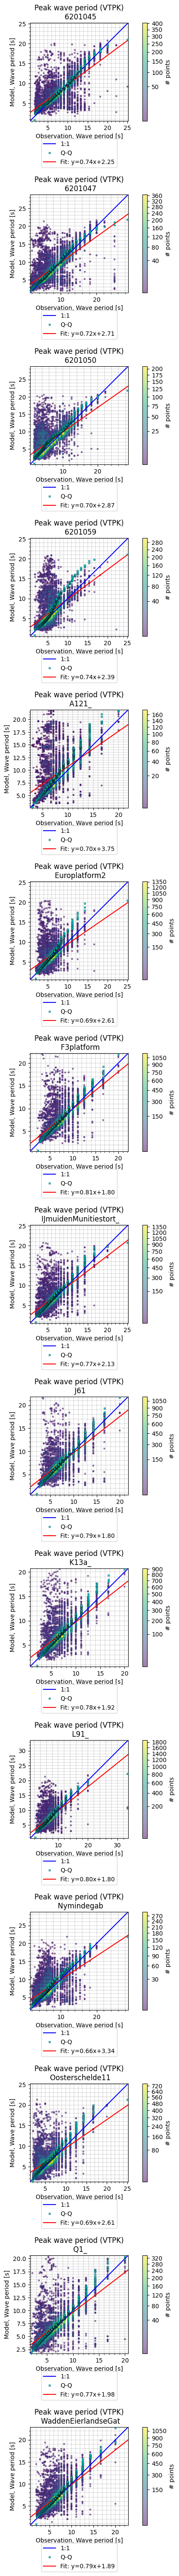

In [139]:
pl.plot_scatter_cc(cc_tp, title="Peak wave period (VTPK)")

#### Scatter with aux

In [140]:
def plot_scatter_cc_aux(cc, title, threshold):    
    n_points = 10000
    fig, axs = plt.subplots(len(cc), 1, figsize=(9, 4*len(cc)))

    # Make sure axs is always iterable
    if len(cc) == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i in range(len(cc)):
        (cc[i].where(cc[i].data['VHM0']>threshold) # filter out low wave heights for better comparison
        .plot.scatter(ax=axs[i], show_points=n_points))
        axs[i].set_title(title + f"\n {cc[i].name}")
        axs[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1)

    plt.tight_layout()
    plt.show()

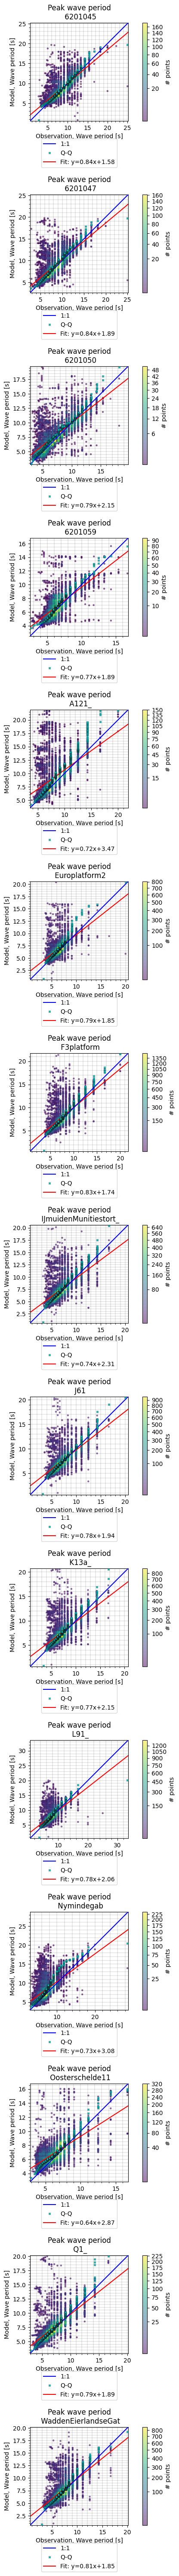

In [141]:
plot_scatter_cc_aux(cc_tp, title="Peak wave period", threshold=1.0)

### Mean wave direction

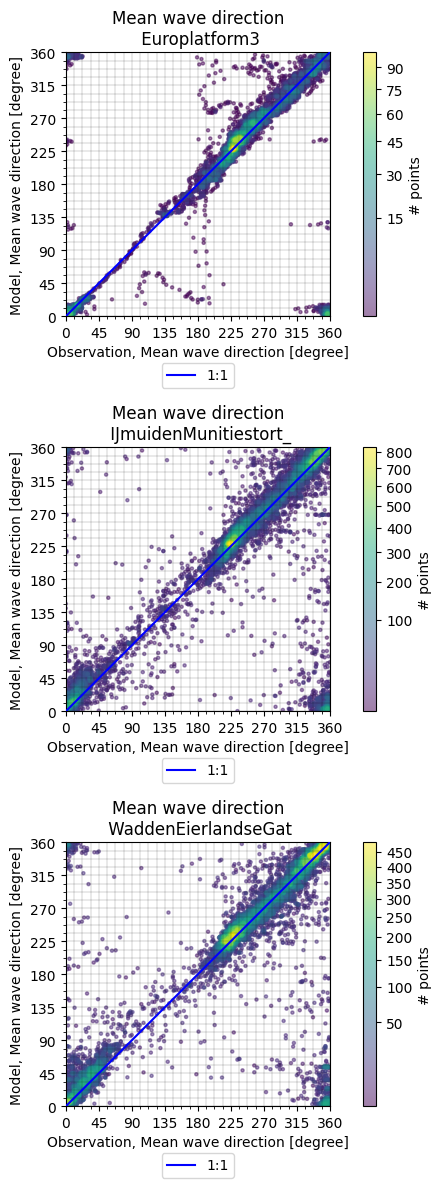

In [142]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_mwd, title='Mean wave direction')

## Timeseries

### Peak wave period

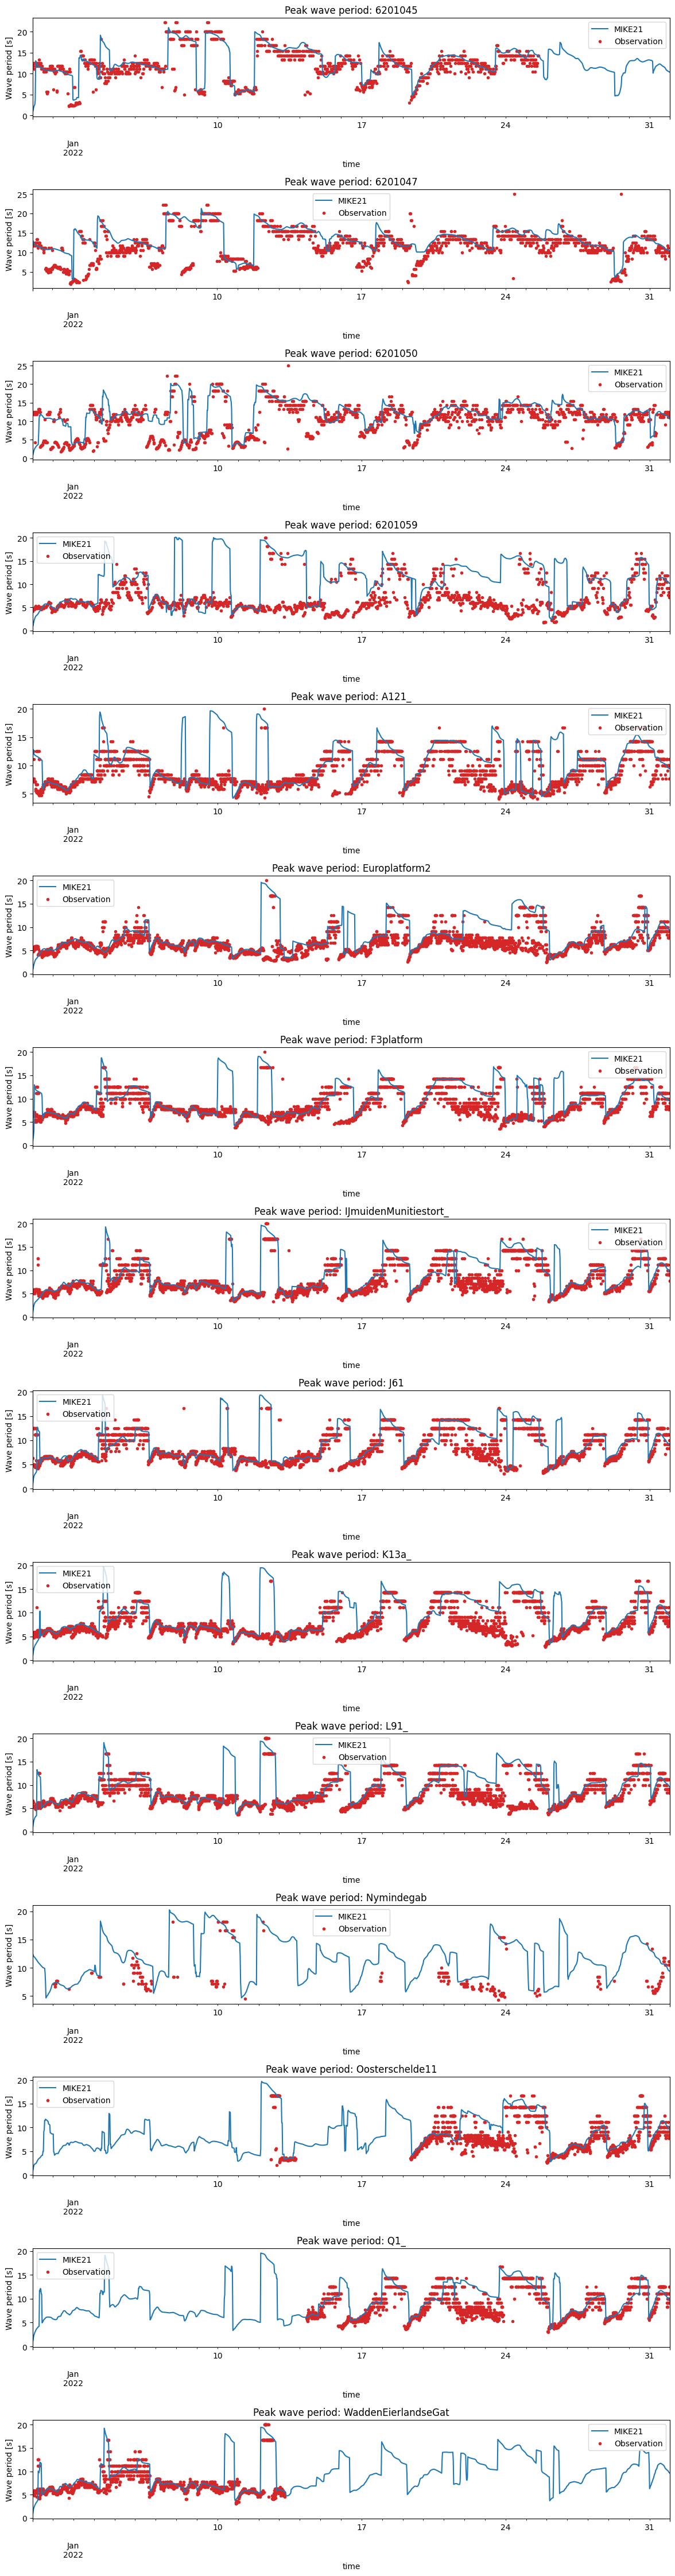

In [143]:
pl.plot_timeseries_currents(cc = cc_tp, title='Peak wave period')

## KDE plot

### Mean wave direction

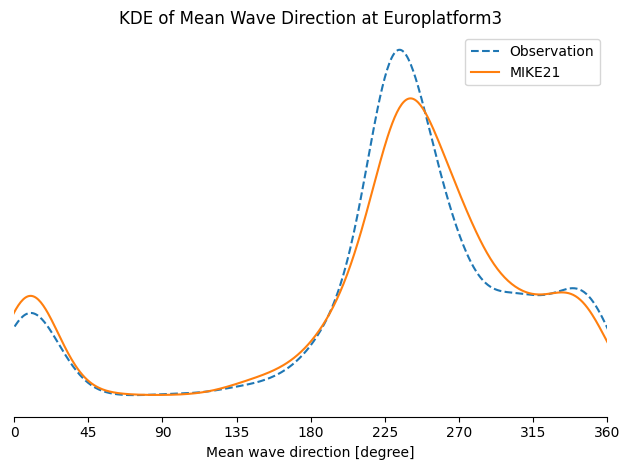

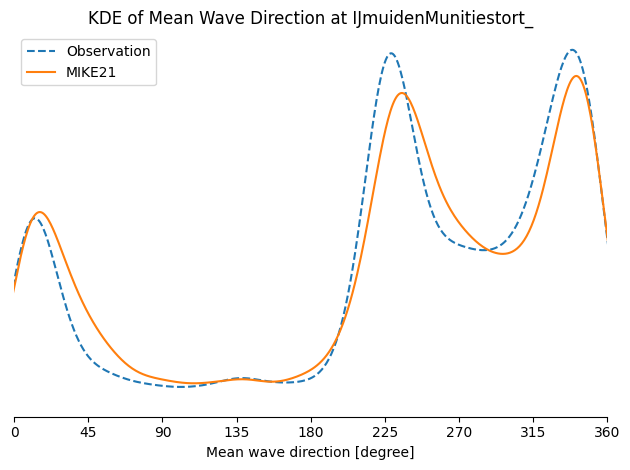

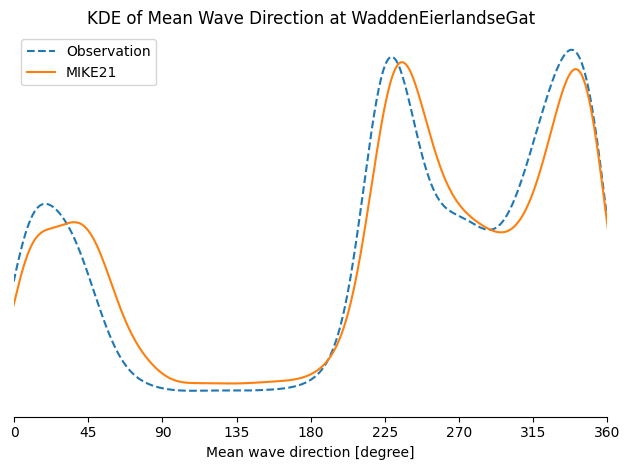

In [144]:
for cc in cc_mwd:
    ax = cc.plot.kde(xlim=(0, 360))
    ax.set_title(f"KDE of Mean Wave Direction at {cc.name}")
    plt.tight_layout()
plt.show()